## Prediction Models
Predict the instrument based on the input csv files from build dataset.
Uses various sklearn classification models and plots error%

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### Load the Datasets
Load the data from the created csv files.

In [11]:
df_test = pd.read_csv('test.csv')
df_valid = pd.read_csv('valid.csv')

### Prepare the Datasets
Balances the data so that both classes have equal entries, to help balance the classification of our implementations.

Seperates the target and data of the classes.

In [12]:
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
   
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class1_copy = pd.concat(temp)
        class1_copy = class1_copy[:class2_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

# balance the datasets
input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 1])
input_df_valid = equalize_data(df_valid[df_valid['target'] == 0], df_valid[df_valid['target'] == 1])

# randomize datasets
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)
input_df_valid = input_df_valid.sample(frac=1).reset_index(drop=True)

# Separate the target and the columns
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target'], axis=1)
#Remove the string column
x_test = x_test.drop(x_test.columns[0], axis=1)

# Separate the target and the columns
y_valid = input_df_valid['target']
x_valid = input_df_valid.drop(labels=['target'], axis=1)
#Remove the string column
x_valid = x_valid.drop(x_valid.columns[0], axis=1)

data_length_test = len(x_test)
data_length_valid = len(x_valid)

### Binary Decision Tree
The first algorithm we used was a Binary Decision Tree. The tree was created and fit to the data using a Sci-kit learn decision tree. Sci-kit learn uses an optimised version of the Classification and Regression Trees (CART) algorithm to construct its decision trees. The CART algorithm “constructs binary trees using the feature and threshold that yield the largest information gain at each node.”

Reference: https://scikit-learn.org/stable/modules/tree.html

In [13]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Decision Tree: Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)


Validation set error percentage:  0.0
Test set error percentage:  1.31


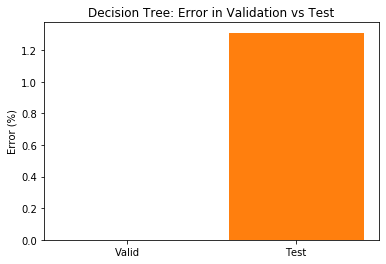

In [14]:
# fit a tree to our data and plot error
simple_decision_tree(4)

### Random Forest
The forest was created and fit to the data using a Sci-kit learn random forest. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Reference: https://scikit-learn.org/stable/modules/ensemble.html#forest

In [127]:
# random forest implementation
def random_forest(max_depth):
    # hyperparameters
    # max_depth of 4 or 5 seems to work well for training with validation set

    # create a scikit-learn random forest based on validation set
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=100, max_features="sqrt", min_samples_split=2)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Random Forest: Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)

Validation set error percentage:  0.0
Test set error percentage:  0.33


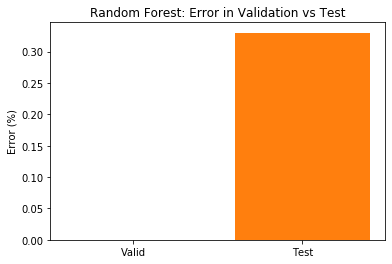

In [162]:
# fit a tree to our data and plot error
random_forest(5)

### AdaBoost
The second algorithm used was AdaBoost which was implemented with Sci-kit learn. Sci-kit learn allows you to define a base estimator which defaults to a DecisionTreeClassifier with a max depth of 1. An estimator is a simple model that can give a classification. Sci-kit learn implements the AdaBoost algorithm to apply heavier weights to specific training estimators with the goal of correcting wrong predictions.

Reference: https://scikit-learn.org/stable/modules/ensemble.html#adaboost  

In [197]:
def ada_boost(estimators):
    classifier = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=estimators
    )
    classifier.fit(x_test, y_test)
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    predictions_valid = classifier.predict(x_valid)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    num_errors_test = results_test[0][1] + results_test[1][0]
    num_errors_valid = results_valid[0][1] + results_valid[1][0]
    
    # calculating valid and test error to two decimal places
    data_length_test = len(predictions_test)
    data_length_valid = len(predictions_valid)
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)

Validation set error percentage:  0.55
Test set error percentage:  0.0


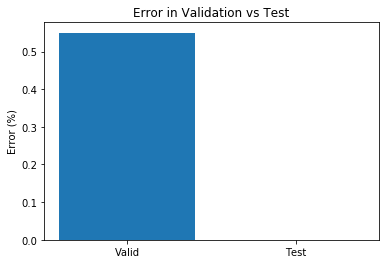

In [198]:
ada_boost(50)